**START**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50,InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os

1.13.1


In [2]:
tf.keras.backend.clear_session()

In [3]:
TRAIN_DIR = "D:/Download/Wild_Edible_Plants/datasets - Copy/train" #TRAIN_DIR Path 
VAL_DIR = "D:/Download/Wild_Edible_Plants/datasets - Copy/val"     #VAL_DIR Path
TEST_DIR = "D:/Download/Wild_Edible_Plants/datasets - Copy/test"   #TEST_DIR Path
METADATA = "D:/Download/1.Edible_Wild_Plants/edible_plants.csv"    #METADATA_DIR Path

In [4]:
metadata = pd.read_csv(METADATA)
print(metadata.head())

  plant_name                                        description  status  \
0     Allium  Tanaman dalam genus bawang, termasuk bawang pu...  Edible   
1     Borage  Daun borage memiliki rasa gurih seperti mentim...  Edible   
2    Burdock  Akar burdock sering digunakan dalam masakan As...  Edible   
3  Calendula  Kelopak bunga yang dapat dimakan, sering digun...  Edible   
4    Cattail  Bagian akar dan pucuk muda cattail dapat dimak...  Edible   

                                           nutrition  
0  Mengandung senyawa sulfur, vitamin C, vitamin ...  
1  Kaya akan asam lemak gamma-linolenic (GLA), vi...  
2  Sumber serat prebiotik, kalium, magnesium, dan...  
3   Mengandung flavonoid, karotenoid, dan vitamin C.  
4        Mengandung karbohidrat, protein, dan serat.  


In [5]:
augmen_train = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2], 
    fill_mode='nearest'
)

augmen_val = ImageDataGenerator(rescale=1./255)

train_generator = augmen_train.flow_from_directory(
    directory="D:/Download/1.Edible_Wild_Plants/resized train",
    target_size=(224, 224),
    batch_size=64,
    shuffle=True,
    subset="training",
    seed=42
)

validation_generator = augmen_val.flow_from_directory(
    directory="D:/Download/1.Edible_Wild_Plants/resized val",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=64,
    shuffle=False, 
    seed=42
)

test_generator = augmen_val.flow_from_directory(
    directory="D:/Download/1.Edible_Wild_Plants/resized test",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    shuffle=False, 
    seed=42
)

Found 12048 images belonging to 34 classes.
Found 3215 images belonging to 34 classes.
Found 813 images belonging to 34 classes.


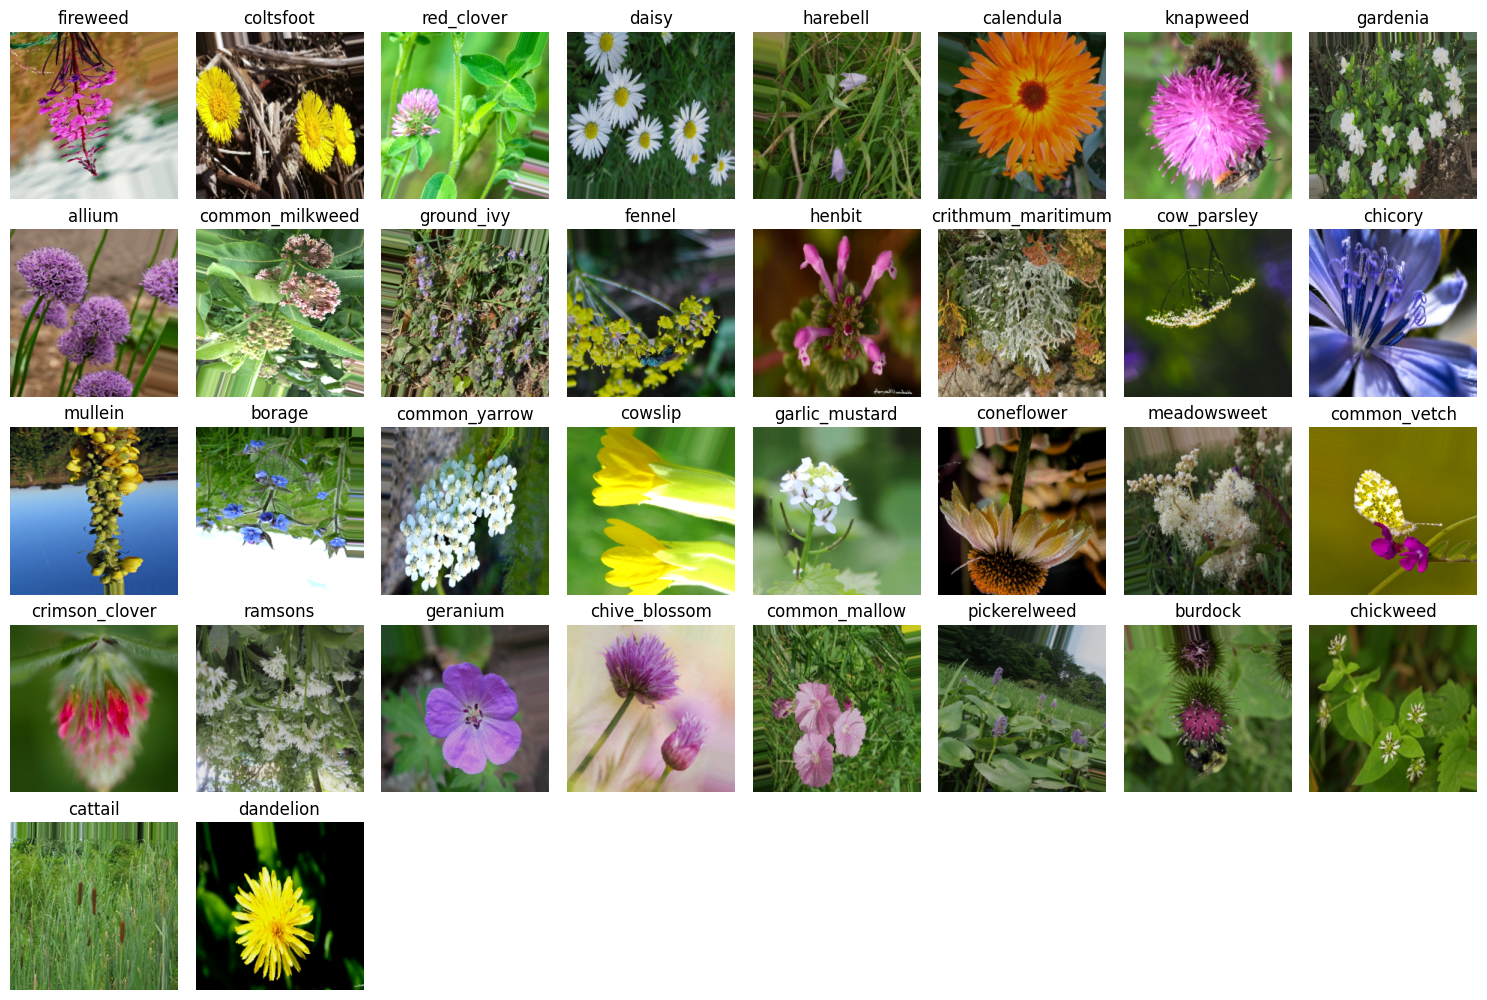

In [ ]:
class_names = list(train_generator.class_indices.keys())
train_generator.reset()
class_images = {}

while len(class_images) < len(class_names):
    images, labels = next(train_generator)
    for img, lbl in zip(images, labels):
        class_idx = lbl.argmax()
        class_name = class_names[class_idx]
        if class_name not in class_images:
            class_images[class_name] = img
            if len(class_images) == len(class_names):
                break

rows = 8
cols = (62 // rows) + 1 

plt.figure(figsize=(15, 2 * rows))
for i, (class_name, img) in enumerate(class_images.items()):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(class_name)

plt.tight_layout()
plt.show()

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-15]:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(34, activation='softmax')
])

model.compile(optimizer=Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 34)                69666     
                                                                 
Total params: 21,880,642
Trainable params: 468,642
Non-t

In [8]:
print(f'Input shape: {model.input_shape}')
print(f'Output shape: {model.output_shape}')

Input shape: (None, 224, 224, 3)
Output shape: (None, 34)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [10]:
history = model.fit(
    train_generator,
    epochs=35,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/35
189/189 [==============================] - 257s 1s/step - loss: 3.2810 - accuracy: 0.2297 - val_loss: 1.6912 - val_accuracy: 0.5683
Epoch 2/35
189/189 [==============================] - 227s 1s/step - loss: 2.0040 - accuracy: 0.4646 - val_loss: 1.1837 - val_accuracy: 0.6781
Epoch 3/35
189/189 [==============================] - 189s 994ms/step - loss: 1.5933 - accuracy: 0.5601 - val_loss: 0.9958 - val_accuracy: 0.7269
Epoch 4/35
189/189 [==============================] - 388s 2s/step - loss: 1.3526 - accuracy: 0.6218 - val_loss: 0.8813 - val_accuracy: 0.7568
Epoch 5/35
189/189 [==============================] - 328s 2s/step - loss: 1.2035 - accuracy: 0.6575 - val_loss: 0.8104 - val_accuracy: 0.7729
Epoch 6/35
189/189 [==============================] - 267s 1s/step - loss: 1.0939 - accuracy: 0.6863 - val_loss: 0.7544 - val_accuracy: 0.7866
Epoch 7/35
189/189 [==============================] - 274s 1s/step - loss: 1.0057 - accuracy: 0.7131 - val_loss: 0.7127 - val_accuracy: 0.7

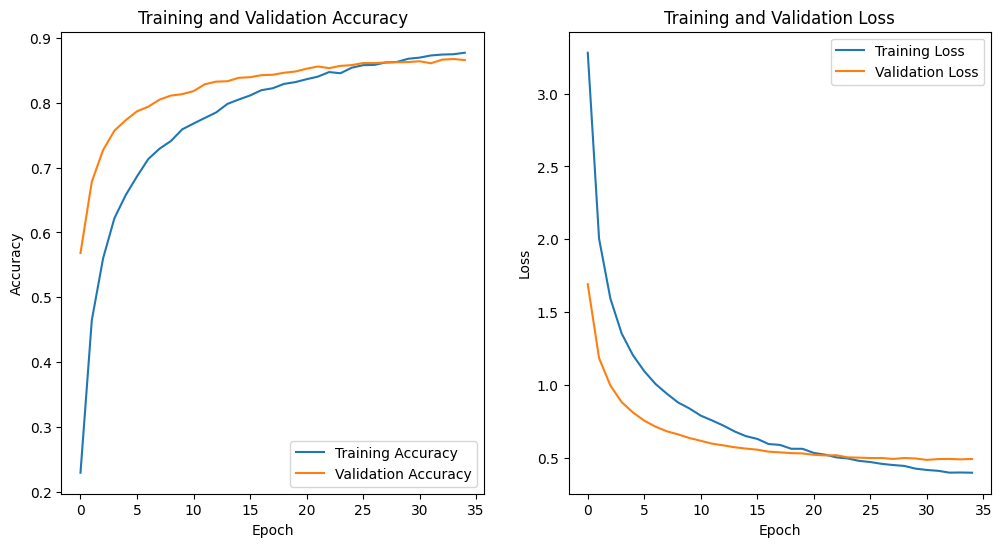

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [12]:
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(validation_generator)

print(f"Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")


51/51 [==============================] - 26s 512ms/step - loss: 0.4911 - accuracy: 0.8656
Training Accuracy: 0.9309, Validation Accuracy: 0.8656


In [13]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

26/26 [==============================] - 8s 291ms/step - loss: 0.4585 - accuracy: 0.8721
Training Accuracy: 0.9309, Test Accuracy: 0.8721


**PREDICTIONSS**

In [14]:
saved_model_path = "./my_model.h5"
model.save(saved_model_path)

1/1 [==============================] - 3s 3s/step
Gambar: Borage.jpg


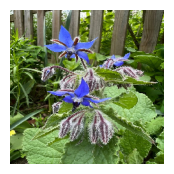

Prediksi: borage (Confidence: 0.95)
Status: Edible
Deskripsi: Daun borage memiliki rasa gurih seperti mentimun dan sering digunakan dalam salad atau teh herbal.
Nutrisi: Kaya akan asam lemak gamma-linolenic (GLA), vitamin C, dan serat.

1/1 [==============================] - 0s 84ms/step
Gambar: Chickweed.jpg


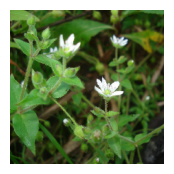

Prediksi: chickweed (Confidence: 0.98)
Status: Edible
Deskripsi: Tanaman herba kecil dengan daun yang dapat dimakan mentah atau dimasak.
Nutrisi: Kaya akan vitamin C, vitamin A, dan zat besi.

1/1 [==============================] - 0s 83ms/step
Gambar: chive-blossom.jpg


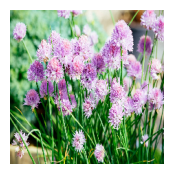

Prediksi: meadowsweet (Confidence: 0.64)
Status: Non-Edible, Better Not Eat The Plants Because Confidence is Low

1/1 [==============================] - 0s 85ms/step
Gambar: Coneflower-and-butterfly.jpg


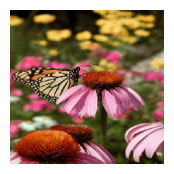

Prediksi: coneflower (Confidence: 0.96)
Status: Edible
Deskripsi: Dikenal juga sebagai Echinacea, sering digunakan dalam teh herbal untuk mendukung kekebalan tubuh.
Nutrisi: Mengandung antioksidan, vitamin C, dan senyawa imunomodulator.

1/1 [==============================] - 0s 72ms/step
Gambar: dandelion.jpg


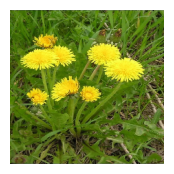

Prediksi: dandelion (Confidence: 0.98)
Status: Edible
Deskripsi: Daun, bunga, dan akar dandelion semuanya dapat dimakan, sering digunakan dalam salad atau teh herbal.
Nutrisi: Kaya akan vitamin A, vitamin C, zat besi, dan kalsium.

1/1 [==============================] - 0s 67ms/step
Gambar: Desktop.png


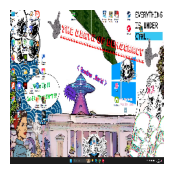

Prediksi: crithmum maritimum (Confidence: 0.70)
Status: Non-Edible, Better Not Eat The Plants Because Confidence is Low

1/1 [==============================] - 0s 82ms/step
Gambar: fireweed-and-human.jpg


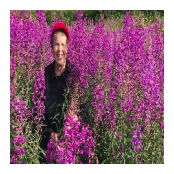

Prediksi: fireweed (Confidence: 0.81)
Status: Edible
Deskripsi: Daun muda dapat dimakan mentah, sementara pucuk dan bunga sering digunakan dalam teh herbal.
Nutrisi: Kaya akan vitamin A, vitamin C, dan antioksidan.

1/1 [==============================] - 0s 93ms/step
Gambar: Fireweed.jpg


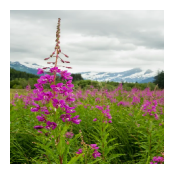

Prediksi: fireweed (Confidence: 1.00)
Status: Edible
Deskripsi: Daun muda dapat dimakan mentah, sementara pucuk dan bunga sering digunakan dalam teh herbal.
Nutrisi: Kaya akan vitamin A, vitamin C, dan antioksidan.

1/1 [==============================] - 0s 87ms/step
Gambar: Garlic-mustard-and-insect.jpg


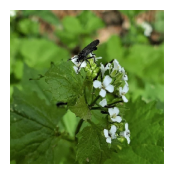

Prediksi: garlic mustard (Confidence: 1.00)
Status: Edible
Deskripsi: Daun dengan rasa pedas seperti bawang putih, sering digunakan dalam salad atau pesto.
Nutrisi: Mengandung vitamin A, vitamin C, dan kalsium.

1/1 [==============================] - 0s 60ms/step
Gambar: groud-ivy.jpg


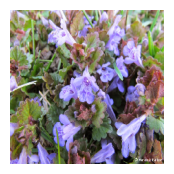

Prediksi: ground ivy (Confidence: 1.00)
Status: Edible
Deskripsi: Daun sering digunakan sebagai bumbu masakan atau dalam teh herbal.
Nutrisi: Kaya akan vitamin C dan antioksidan.

1/1 [==============================] - 0s 88ms/step
Gambar: groundivy-nad-big-finger.jpg


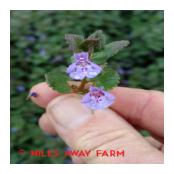

Prediksi: henbit (Confidence: 0.52)
Status: Non-Edible, Better Not Eat The Plants Because Confidence is Low

1/1 [==============================] - 0s 84ms/step
Gambar: morning-glory-poisonous(non-edible).jpg


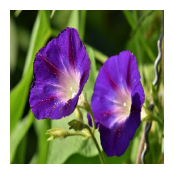

Prediksi: geranium (Confidence: 0.64)
Status: Non-Edible, Better Not Eat The Plants Because Confidence is Low

1/1 [==============================] - 0s 53ms/step
Gambar: Poison-Plants(non-edible).jpg


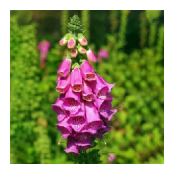

Prediksi: fireweed (Confidence: 0.50)
Status: Non-Edible, Better Not Eat The Plants Because Confidence is Low

1/1 [==============================] - 0s 57ms/step
Gambar: Red-clover.jpg


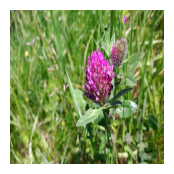

Prediksi: red clover (Confidence: 0.96)
Status: Edible
Deskripsi: Bunga merah sering digunakan dalam teh herbal atau salad.
Nutrisi: Kaya akan isoflavon, vitamin C, dan zat besi.



In [30]:
image_size = 224  

model = tf.keras.models.load_model('D:/OneDrive/Dokumen/Bangkit Academy/my_model.h5')

USER_IMAGE_DIR = "D:/Download/1.Edible_Wild_Plants/user_image"
METADATA = "D:/Download/1.Edible_Wild_Plants/edible_plants.csv"

label_df = pd.read_csv(METADATA)

class_info = dict(zip(label_df['plant_name'].str.lower(), zip(label_df['description'], label_df['status'], label_df['nutrition'])))

class_names = label_df['plant_name'].str.lower().tolist()

def show_image(image_path):
    img = image.load_img(image_path, target_size=(image_size, image_size))
    

    plt.figure(figsize=(2, 2))
    plt.imshow(img)
    plt.axis('off') 
    plt.show()

for img_file in os.listdir(USER_IMAGE_DIR):
    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(USER_IMAGE_DIR, img_file)

        img = image.load_img(img_path, target_size=(image_size, image_size))
        img_array = image.img_to_array(img) / 255.0  
        img_array = np.expand_dims(img_array, axis=0) 

        predictions = model.predict(img_array)
        predicted_class = class_names[np.argmax(predictions)]
        confidence = np.max(predictions)

        print(f"Gambar: {img_file}")
        show_image(img_path)

        if confidence < 0.77:
            status = "Non-Edible, Better Not Eat The Plants Because Confidence is Low"
            print(f"Prediksi: {predicted_class} (Confidence: {confidence:.2f})")
            print(f"Status: {status}\n")
        else:
            status = "Edible, It's Safe If You Want To Eat The Plants Because Confidence is High"
            plant_info = class_info.get(predicted_class.lower(), ("No Description Available", "No Status Available", "No Nutritional Info Available"))
            
            description = plant_info[0]
            status = plant_info[1]
            nutrition = plant_info[2]

            print(f"Prediksi: {predicted_class} (Confidence: {confidence:.2f})")
            print(f"Status: {status}")
            print(f"Deskripsi: {description}")
            print(f"Nutrisi: {nutrition}\n")


In [16]:
export_dir = 'D:/OneDrive/Dokumen/Bangkit Academy/saved_model/1'

tf.saved_model.save(model,export_dir)

INFO:tensorflow:Assets written to: D:/OneDrive/Dokumen/Bangkit Academy/saved_model/1\assets


INFO:tensorflow:Assets written to: D:/OneDrive/Dokumen/Bangkit Academy/saved_model/1\assets


In [17]:
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]


tflite_model = converter.convert()

In [21]:
import pathlib


tflite_model_file = pathlib.Path('./survPlant.tflite')
tflite_model_file.write_bytes(tflite_model)

22162736

Gambar: Borage.jpg


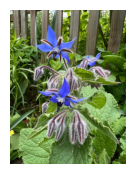

Prediksi: borage (Confidence: 0.99)
Status: Edible
Deskripsi: Daun borage memiliki rasa gurih seperti mentimun dan sering digunakan dalam salad atau teh herbal.
Nutrisi: Kaya akan asam lemak gamma-linolenic (GLA), vitamin C, dan serat.

Gambar: Chickweed.jpg


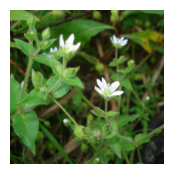

Prediksi: chickweed (Confidence: 0.99)
Status: Edible
Deskripsi: Tanaman herba kecil dengan daun yang dapat dimakan mentah atau dimasak.
Nutrisi: Kaya akan vitamin C, vitamin A, dan zat besi.

Gambar: chive-blossom.jpg


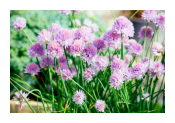

Prediksi: meadowsweet (Confidence: 0.56)
Status: Non-Edible, Better Not Eat The Plants Because Confidence is Low

Gambar: Coneflower-and-butterfly.jpg


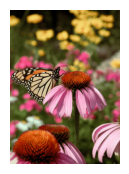

Prediksi: coneflower (Confidence: 0.97)
Status: Edible
Deskripsi: Dikenal juga sebagai Echinacea, sering digunakan dalam teh herbal untuk mendukung kekebalan tubuh.
Nutrisi: Mengandung antioksidan, vitamin C, dan senyawa imunomodulator.

Gambar: dandelion.jpg


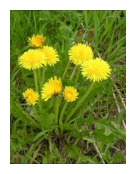

Prediksi: dandelion (Confidence: 0.98)
Status: Edible
Deskripsi: Daun, bunga, dan akar dandelion semuanya dapat dimakan, sering digunakan dalam salad atau teh herbal.
Nutrisi: Kaya akan vitamin A, vitamin C, zat besi, dan kalsium.

Gambar: Desktop.png


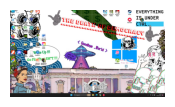

Prediksi: crithmum maritimum (Confidence: 0.76)
Status: Non-Edible, Better Not Eat The Plants Because Confidence is Low

Gambar: fireweed-and-human.jpg


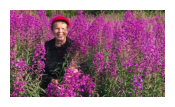

Prediksi: fireweed (Confidence: 0.95)
Status: Edible
Deskripsi: Daun muda dapat dimakan mentah, sementara pucuk dan bunga sering digunakan dalam teh herbal.
Nutrisi: Kaya akan vitamin A, vitamin C, dan antioksidan.

Gambar: Fireweed.jpg


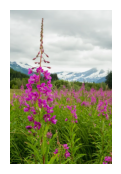

Prediksi: fireweed (Confidence: 1.00)
Status: Edible
Deskripsi: Daun muda dapat dimakan mentah, sementara pucuk dan bunga sering digunakan dalam teh herbal.
Nutrisi: Kaya akan vitamin A, vitamin C, dan antioksidan.

Gambar: Garlic-mustard-and-insect.jpg


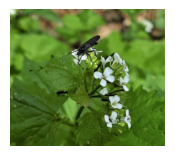

Prediksi: garlic mustard (Confidence: 0.98)
Status: Edible
Deskripsi: Daun dengan rasa pedas seperti bawang putih, sering digunakan dalam salad atau pesto.
Nutrisi: Mengandung vitamin A, vitamin C, dan kalsium.

Gambar: groud-ivy.jpg


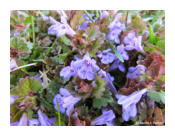

Prediksi: ground ivy (Confidence: 1.00)
Status: Edible
Deskripsi: Daun sering digunakan sebagai bumbu masakan atau dalam teh herbal.
Nutrisi: Kaya akan vitamin C dan antioksidan.

Gambar: groundivy-nad-big-finger.jpg


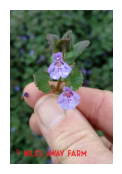

Prediksi: mullein (Confidence: 0.56)
Status: Non-Edible, Better Not Eat The Plants Because Confidence is Low

Gambar: morning-glory-poisonous(non-edible).jpg


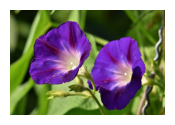

Prediksi: geranium (Confidence: 0.87)
Status: Edible
Deskripsi: Kelopak bunga sering digunakan dalam teh herbal atau sebagai hiasan makanan.
Nutrisi: Mengandung antioksidan dan senyawa antiinflamasi.

Gambar: Poison-Plants(non-edible).jpg


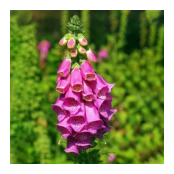

Prediksi: fireweed (Confidence: 0.56)
Status: Non-Edible, Better Not Eat The Plants Because Confidence is Low

Gambar: Red-clover.jpg


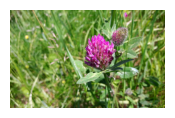

Prediksi: red clover (Confidence: 0.96)
Status: Edible
Deskripsi: Bunga merah sering digunakan dalam teh herbal atau salad.
Nutrisi: Kaya akan isoflavon, vitamin C, dan zat besi.



In [29]:

image_size = 224
tflite_model_path = 'D:/OneDrive/Dokumen/Bangkit Academy/survPlant.tflite'  # Path model TFLite
USER_IMAGE_DIR = "D:/Download/1.Edible_Wild_Plants/user_image"  # Folder berisi gambar
METADATA = "D:/Download/1.Edible_Wild_Plants/edible_plants.csv"  # Metadata tanaman

label_df = pd.read_csv(METADATA)
class_info = dict(zip(label_df['plant_name'].str.lower(), 
                      zip(label_df['description'], label_df['status'], label_df['nutrition'])))
class_names = label_df['plant_name'].str.lower().tolist()

def show_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(2, 2))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def prepare_input(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (image_size, image_size))
    image = np.expand_dims(image, axis=0).astype(np.float32) / 255.0
    return image

for img_file in os.listdir(USER_IMAGE_DIR):
    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(USER_IMAGE_DIR, img_file)
        input_data = prepare_input(img_path)

        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        predictions = interpreter.get_tensor(output_details[0]['index'])[0]

        predicted_class = class_names[np.argmax(predictions)]
        confidence = np.max(predictions)

        print(f"Gambar: {img_file}")
        show_image(img_path)

        if confidence < 0.77:
            status = "Non-Edible, Better Not Eat The Plants Because Confidence is Low"
            print(f"Prediksi: {predicted_class} (Confidence: {confidence:.2f})")
            print(f"Status: {status}\n")
        else:
            status = "Edible, It's Safe If You Want To Eat The Plants Because Confidence is High"
            plant_info = class_info.get(predicted_class.lower(), 
                                        ("No Description Available", "No Status Available", "No Nutritional Info Available"))
            description = plant_info[0]
            status = plant_info[1]
            nutrition = plant_info[2]

            print(f"Prediksi: {predicted_class} (Confidence: {confidence:.2f})")
            print(f"Status: {status}")
            print(f"Deskripsi: {description}")
            print(f"Nutrisi: {nutrition}\n")
